In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torch import nn, optim

from time import time
import random as r

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

datapath = "/content/gdrive/My Drive/Datasets/Loans/"

si = SimpleImputer(missing_values=np.nan, strategy="mean")

# Helper Functions

In [3]:
def breaker():
  print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
  breaker()
  print(x[:no_of_ele])
  breaker()

def getCol(x):
  return [col for col in x.columns]

def getObjCols(x):
  s = (x.dtypes == "object")
  return list(s[s].index)

def preprocess(x, *args):
  df = x.copy()
  df[args[0]] = df[args[0]].map({"Male" : 1, "Female" : 0})
  df[args[1]] = df[args[1]].map({"Yes" : 1, "No" : 0})
  df[args[2]] = df[args[2]].map({"0" : 0, "1" : 1, "2" : 2, "3+" : 3})
  df[args[3]] = df[args[3]].map({"Not Graduate" : 0, "Graduate" : 1})
  df[args[4]] = df[args[4]].map({"Yes" : 1, "No" : 0})
  df[args[5]] = df[args[5]].map({"Rural" : 0, "Semiurban" : 1, "Urban" : 2})
  df[args[6]] = df[args[6]].map({"Y" : 1, "N" : 0})
  return df

# Data Handling

**Input**

In [4]:
dataset = pd.read_csv(datapath + "Loans_2.csv")

breaker()
print(dataset.head(5))
breaker()
print(dataset.shape)
breaker()
print(getCol(dataset))
breaker()
print(getObjCols(dataset))
breaker()

df = preprocess(dataset, "Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area", "Loan_Status")


------------------------------

    Loan_ID Gender Married  ... Credit_History Property_Area Loan_Status
0  LP001002   Male      No  ...            1.0         Urban           Y
1  LP001003   Male     Yes  ...            1.0         Rural           N
2  LP001005   Male     Yes  ...            1.0         Urban           Y
3  LP001006   Male     Yes  ...            1.0         Urban           Y
4  LP001008   Male      No  ...            1.0         Urban           Y

[5 rows x 13 columns]

------------------------------

(614, 13)

------------------------------

['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

------------------------------

['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

------------------------------



**Preprocessing**

In [5]:
final_df_X = df.iloc[:, 1:-1].copy().values
final_df_y = df.iloc[:, -1].copy().values

final_df_X = si.fit_transform(final_df_X)

X, X_test, y, y_test = train_test_split(final_df_X, final_df_y, test_size=114, shuffle=True, random_state=0)

# Sklearn and XGB

In [6]:
accs = []
f1_s = []

########## MLR ##########
mlr = LinearRegression()
mlr.fit(X, y)
y_pred = mlr.predict(X_test)

y_pred[(np.argwhere(y_pred <= 0.5)[:, 0])] = 0
y_pred[(np.argwhere(y_pred > 0.5)[:, 0])]  = 1

breaker()
print("MLR Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
print("MLR F1 Score : {:.5f}".format(f1_score(y_test, y_pred)))
accs.append(accuracy_score(y_test, y_pred) * 100)
f1_s.append(f1_score(y_test, y_pred))

########## KNC ##########
knc = KNeighborsClassifier()
knc.fit(X, y)
y_pred = knc.predict(X_test)

breaker()
print("KNC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
print("KNC F1 Score : {:.5f}".format(f1_score(y_test, y_pred)))
accs.append(accuracy_score(y_test, y_pred) * 100)
f1_s.append(f1_score(y_test, y_pred))

########## SVC ##########
svc = SVC(kernel="rbf")
svc.fit(X, y)
y_pred = svc.predict(X_test)

breaker()
print("SVC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
print("SVC F1 Score : {:.5f}".format(f1_score(y_test, y_pred)))
accs.append(accuracy_score(y_test, y_pred) * 100)
f1_s.append(f1_score(y_test, y_pred))

########## GNB ##########
gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X_test)

breaker()
print("GNB Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
print("GNB F1 Score : {:.5f}".format(f1_score(y_test, y_pred)))
accs.append(accuracy_score(y_test, y_pred) * 100)
f1_s.append(f1_score(y_test, y_pred))

########## DTC ##########
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X, y)
y_pred = dtc.predict(X_test)

breaker()
print("DTC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
print("DTC F1 Score : {:.5f}".format(f1_score(y_test, y_pred)))
accs.append(accuracy_score(y_test, y_pred) * 100)
f1_s.append(f1_score(y_test, y_pred))

########## RFC ##########
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X, y)
y_pred = rfc.predict(X_test)

breaker()
print("RFC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
print("RFC F1 Score : {:.5f}".format(f1_score(y_test, y_pred)))
accs.append(accuracy_score(y_test, y_pred) * 100)
f1_s.append(f1_score(y_test, y_pred))

########## XGR ##########
xgc = XGBClassifier()
xgc.fit(X, y)
y_pred = xgc.predict(X_test)

breaker()
print("XGC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
print("XGC F1 Score : {:.5f}".format(f1_score(y_test, y_pred)))
accs.append(accuracy_score(y_test, y_pred) * 100)
f1_s.append(f1_score(y_test, y_pred))
breaker()


------------------------------

MLR Accuracy : 83.3333 %
MLR F1 Score : 0.89617

------------------------------

KNC Accuracy : 64.0351 %
KNC F1 Score : 0.76836

------------------------------

SVC Accuracy : 72.8070 %
SVC F1 Score : 0.84264

------------------------------

GNB Accuracy : 82.4561 %
GNB F1 Score : 0.89011

------------------------------

DTC Accuracy : 72.8070 %
DTC F1 Score : 0.80255

------------------------------

RFC Accuracy : 78.0702 %
RFC F1 Score : 0.86034

------------------------------

XGC Accuracy : 80.7018 %
XGC F1 Score : 0.87778

------------------------------



# ANN

**Dataset Template**

In [7]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y
    
  def __len__(this):
    return this.X.shape[0]

  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
    else:
      return torch.FloatTenspr(this.X[idx])

In [8]:
X = X.astype(float)
y = y.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

num_features = X.shape[1]
num_obs_test = X_test.shape[0]

In [9]:
class CFG():
  epochs = 100
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  IL = num_features
  HL_1 = [8]
  HL_2 = [16, 16]
  OL = 1

  tr_batch_size = 128
  ts_batch_size = num_obs_test

cfg = CFG()

ts_data_setup = DS(X_test, y_test.reshape(-1,1))
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

In [10]:
class ANN(nn.Module):
  def __init__(this, IL=None, HL=None, OL=None):
    super(ANN, this).__init__()
    this.HL = HL
    this.DP1 = nn.Dropout(p=0.2)
    this.DP2 = nn.Dropout(p=0.5)

    if len(HL) == 1:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], OL))
    elif len(HL) == 2:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], HL[1]))

      this.BN3 = nn.BatchNorm1d(HL[1])
      this.FC3 = WN(nn.Linear(HL[1], OL))
    else:
      raise NotImplementedError("Only Supports Network of Depth 1 and 2")
    
  def getOptimizer(this):
    return optim.Adam(this.parameters(), lr=1e-3, weight_decay=1e-5)

  def forward(this, x):
    if len(this.HL) == 1:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))
      x = this.BN2(x)
      x = this.DP2(x)
      x = torch.sigmoid(this.FC2(x))
      return x
    else:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))
      x = this.BN2(x)
      x = this.DP2(x)
      x = F.relu(this.FC2(x))
      x = this.BN3(x)
      x = this.DP2(x)
      x = torch.sigmoid(this.FC3(x))
      return x

In [11]:
def train_fn(X=None, y=None, HL_Used=None):
  LP = []

  torch.manual_seed(0)
  model = ANN(cfg.IL, HL_Used, cfg.OL)
  model.to(cfg.device)

  optimizer = model.getOptimizer()

  tr_data_setup = DS(X, y.reshape(-1,1))
  tr_data = DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0))

  start_time = time()
  for e in range(cfg.epochs):
    lossPerPass = 0
    for feat, label in tr_data:
      feat, label = feat.to(cfg.device), label.to(cfg.device)

      optimizer.zero_grad()
      output = model(feat)
      loss   = nn.BCELoss()(output, label)
      loss.backward()
      lossPerPass = (loss.item()/label.shape[0])
      optimizer.step()
    LP.append(lossPerPass)

  breaker()
  print("Time Taken to Train for {e} epochs : {:.5f} seconds".format(time()-start_time, e=cfg.epochs))
  breaker()

  return LP, model

def eval_fn(model=None, dataloader=None):
  Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)

  model.eval()
  for X, y in ts_data:
    X = X.to(cfg.device)
    with torch.no_grad():
      Prob = model(X)
    Pred = torch.cat((Pred, Prob), dim=0)

  Pred = Pred[cfg.ts_batch_size:]
  Pred = Pred.cpu().numpy()
  Pred[np.argwhere(Pred > 0.5)[:, 0]]  = int(1)
  Pred[np.argwhere(Pred <= 0.5)[:, 0]] = int(0)
  return Pred.reshape(-1)


------------------------------

Time Taken to Train for 100 epochs : 1.57168 seconds

------------------------------


------------------------------

Time Taken to Train for 100 epochs : 1.85311 seconds

------------------------------



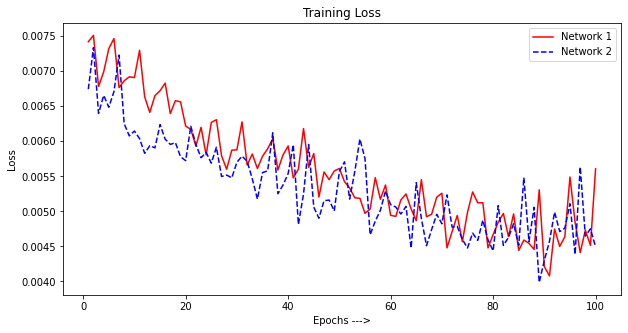

In [12]:
LP_1, Network_1 = train_fn(X=X, y=y, HL_Used=cfg.HL_1)
LP_2, Network_2 = train_fn(X=X, y=y, HL_Used=cfg.HL_2)

x_Axis = [i+1 for i in range(cfg.epochs)]

plt.figure(figsize=(10, 5))
plt.plot(x_Axis, LP_1, "r", label="Network 1")
plt.plot(x_Axis, LP_2, "b--", label="Network 2")
plt.xlabel("Epochs --->")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [13]:
y_pred_1 = eval_fn(Network_1, ts_data)
y_pred_2 = eval_fn(Network_2, ts_data)

breaker()
print("ANN_1 Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred_1) * 100))
print("ANN_1 F1 Score : {:.5f}".format(f1_score(y_test, y_pred_1)))
print("ANN_2 Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred_2) * 100))
print("ANN_2 F1 Score : {:.5f}".format(f1_score(y_test, y_pred_2)))
accs.append(accuracy_score(y_test, y_pred_1) * 100)
f1_s.append(f1_score(y_test, y_pred_1))
accs.append(accuracy_score(y_test, y_pred_2) * 100)
f1_s.append(f1_score(y_test, y_pred_2))
breaker()


------------------------------

ANN_1 Accuracy : 83.3333 %
ANN_1 F1 Score : 0.89617
ANN_2 Accuracy : 82.4561 %
ANN_2 F1 Score : 0.89130

------------------------------



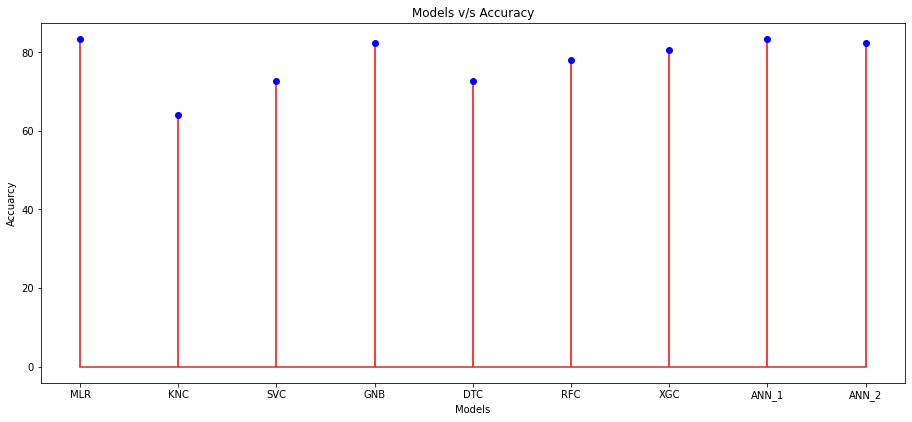

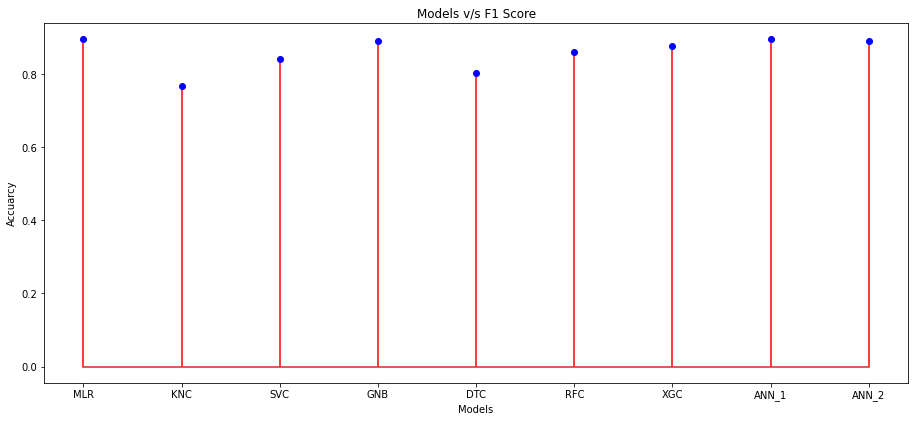

In [14]:
labels = ["MLR", "KNC", "SVC", "GNB", "DTC", "RFC", "XGC", "ANN_1", "ANN_2"]

x_Axis = [i for i in range(len(accs))]

fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([1, 1, 1, 1])
ax.stem(x_Axis, accs, markerfmt="bo", linefmt="r-", use_line_collection=True)
ax.set_xlabel("Models")
ax.set_ylabel("Accuarcy")
ax.set_title("Models v/s Accuracy")
ax.set_xticks(x_Axis)
ax.set_xticklabels(labels)
plt.show()

fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([1, 1, 1, 1])
ax.stem(x_Axis, f1_s, markerfmt="bo", linefmt="r-", use_line_collection=True)
ax.set_xlabel("Models")
ax.set_ylabel("Accuarcy")
ax.set_title("Models v/s F1 Score")
ax.set_xticks(x_Axis)
ax.set_xticklabels(labels)
plt.show()